# Machine Learning no Marketing Digital

### Imports e outras inicializações

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Carregamento dos dados

In [2]:
df = pd.read_csv('./datasets/train.csv', dtype={'date':object,'fullVisitorId':object,'VisitId':object})
print(f'Linhas: {df.shape[0]} | Colunas: {df.shape[1]}')

Linhas: 12283 | Colunas: 12


In [3]:
df.head(2)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9674781571160116268,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",9674781571160116268_1472804607,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472804607,1,1472804607
1,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8590648239310839049,"{""continent"": ""Europe"", ""subContinent"": ""Easte...",8590648239310839049_1472835928,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472835928,1,1472835928


In [4]:
print('# usuários únicos da base: ', len(df['fullVisitorId'].unique()))

# usuários únicos da base:  9997


In [5]:
print('Tipos dos dados: ')
df.dtypes

Tipos dos dados: 


channelGrouping         object
date                    object
device                  object
fullVisitorId           object
geoNetwork              object
sessionId               object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                  int64
visitNumber              int64
visitStartTime           int64
dtype: object

### Dicionário dos dados

Link: https://support.google.com/analytics/answer/3437719?hl=pt-BR

- **channelGrouping**: grupo de canais padrão associado a uma sessão do usuário final para essa vista. (object)

- **date**: data da sessão no formato AAAAMMDD. (object)

- **device**: informações sobre os dispositivos dos usuários. (object)

- **fullVisitorId**: id exclusivo do visitante. (object)

- **geoNetwork**: informações sobre a localização geográfica do usuário. (object)

- **sessionId**: id da sessão. (object)

- **socialEngagementType**: tipo de engajamento, seja "Com engajamento social" ou "Sem engajamento social".(object)

- **totals**:  valores agregados em toda a sessão. (object)

- **trafficSource**: informações sobre a origem do tráfego que gerou a sessão. (object)

- **visitId**: identificador para essa sessão. Esse valor só é único para o usuário. (int64)

- **visitNumber**: número da sessão desse usuário. Se for a primeira sessão, o valor será definido como 1. (int64)

- **visitStartTime**: timestamp (expressa no horário POSIX). (int64)

### Desmembrando as colunas que estão em formato de dicionário

In [6]:
import json

dicionarios = ['device', 'geoNetwork', 'trafficSource', 'totals']
for coluna in dicionarios:
    df = df.join(pd.DataFrame([json.loads(linha) for linha in df[coluna]]))

df.drop(dicionarios, axis=1, inplace=True)
print(f'Linhas: {df.shape[0]} | Colunas: {df.shape[1]}')
df.head(2)

Linhas: 12283 | Colunas: 50


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserVersion,...,isTrueDirect,referralPath,adContent,campaignCode,visits,hits,pageviews,bounces,newVisits,transactionRevenue
0,Organic Search,20160902,9674781571160116268,9674781571160116268_1472804607,Not Socially Engaged,1472804607,1,1472804607,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,1,1,1,1,1,NaN
1,Organic Search,20160902,8590648239310839049,8590648239310839049_1472835928,Not Socially Engaged,1472835928,1,1472835928,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,1,1,1,1,1,NaN


### Limpando os dados

Removendo a coluna em forma de dicionário que não traz informação relevante

In [7]:
df.drop(['adwordsClickInfo'], axis=1, inplace=True)

Removendo colunas com apenas 1 valor

In [8]:
coluna_na = []       
coluna_na = [coluna for coluna in df.columns if len(df[coluna].unique()) == 1]
df.drop(coluna_na, axis=1, inplace=True)

Visualizando o total de valores únicos por coluna

In [9]:
for coluna in df.columns:
    print(coluna + ': ' + str(len(df[coluna].unique())))

channelGrouping: 8
date: 366
fullVisitorId: 9997
sessionId: 12276
visitId: 12272
visitNumber: 50
visitStartTime: 12279
browser: 22
operatingSystem: 12
isMobile: 2
deviceCategory: 3
continent: 6
subContinent: 22
country: 145
region: 212
metro: 53
city: 296
networkDomain: 1747
campaign: 7
source: 76
medium: 7
keyword: 129
isTrueDirect: 2
referralPath: 198
adContent: 16
campaignCode: 2
hits: 96
pageviews: 75
bounces: 2
newVisits: 2
transactionRevenue: 147


### Engenharia de features

In [10]:
quantitativas = ['bounces', 'hits', 'newVisits', 'pageviews', 'transactionRevenue']
for coluna in quantitativas:
    df[coluna] = pd.to_numeric(df[coluna])

Tratando a variável resposta

In [11]:
print('% nulos da variável respostas: ', round((df['transactionRevenue'].isna().sum() / df.shape[0]) * 100, 2), '%')
df['transactionRevenue'].fillna(0, inplace=True)

% nulos da variável respostas:  98.66 %


In [12]:
print('Valor multiplicado por 10⁶: ', df['transactionRevenue'][93])
df['transactionRevenue'] = df['transactionRevenue']/1000000
print('Valor real da compra: ', df['transactionRevenue'][93])

Valor multiplicado por 10⁶:  31490000.0
Valor real da compra:  31.49


Criando as variáveis que vão alimentar o modelo

In [13]:
df_quant = df.groupby('fullVisitorId', as_index=False)[quantitativas].sum()
print(f'Linhas: {df_quant.shape[0]} | Colunas: {df_quant.shape[1]}')
df_quant.head()

Linhas: 9997 | Colunas: 6


,fullVisitorId,bounces,hits,newVisits,pageviews,transactionRevenue
0,0002365800130207040,1.0,1,1.0,1,0.0
1,0010286039787739137,0.0,4,1.0,3,0.0
2,0011056874471185769,0.0,2,1.0,2,0.0
3,0014443856125569702,1.0,1,1.0,1,0.0
4,0017260116665815114,0.0,2,0.0,2,0.0


### Separando as bases

In [14]:
y = df_quant['transactionRevenue'].copy()
X = df_quant.drop(['transactionRevenue'], axis=1)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f'Treino: {X_train.shape} + {y_train.shape}')
print(f'Teste:  {X_test.shape}  + {y_test.shape}')

Treino: (6997, 5) + (6997,)
Teste:  (3000, 5)  + (3000,)


### Regressão Linear

In [16]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
_ = reg.fit(X_train, y_train)

In [17]:
pred = reg.predict(X_test)

### Avaliando os resultados

In [18]:
resultados = pd.DataFrame({'revenue': y_test, 'predict': pred, 'erro': pred - y_test})
resultados.head()

,revenue,predict,erro
4122,0.0,1.551660,1.551660
4065,0.0,1.555209,1.555209
1731,0.0,1.687726,1.687726
4740,0.0,1.515492,1.515492
6391,0.0,1.422655,1.422655


In [19]:
resultados.query('revenue>0').head(5)

,revenue,predict,erro
3006,32.49,1.616211,-30.873789
5928,74.85,1.449755,-73.400245
8361,424.50,1.306194,-423.193806
8612,55.99,1.291322,-54.698678
416,15.19,1.831725,-13.358275


### MSE

In [20]:
print(f'MSE: {np.mean((pred - y_test)**2)}')

MSE: 807.245929682092


### RMSE

In [21]:
print(f'RMSE: {np.sqrt(np.mean((pred - y_test)**2))}')

RMSE: 28.412073660366502


In [22]:
from sklearn.metrics import mean_squared_error
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, pred))}')

RMSE: 28.412073660366516


### Média e desvio padrão da base

In [23]:
print('Media de gasto: ', np.mean(df_quant['transactionRevenue']))
print('Desvio padrão: ', np.std(df_quant['transactionRevenue']))

Media de gasto:  1.778953686105831
Desvio padrão:  25.129905708017944


**OBS.**: O modelo está errando mais do que o desvio padrão natural dos dados

### Análise gráfica do modelo

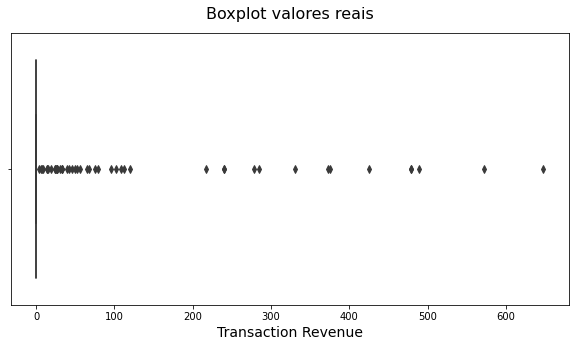

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(y_test, color='c')
plt.title('Boxplot valores reais', fontsize=16, y=1.03)
plt.xlabel('Transaction Revenue', fontsize=14)
plt.show()

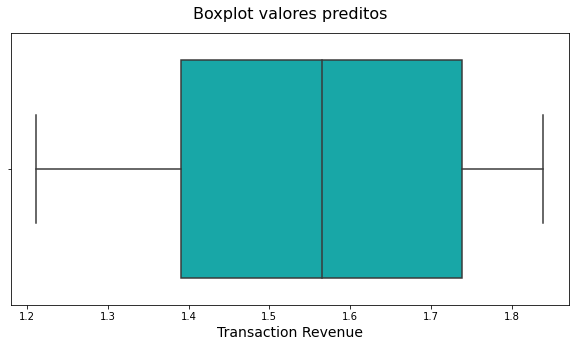

In [25]:
plt.figure(figsize=(10, 5))
sns.boxplot(pred, color='c')
plt.title('Boxplot valores preditos', fontsize=16, y=1.03)
plt.xlabel('Transaction Revenue', fontsize=14)
plt.show()

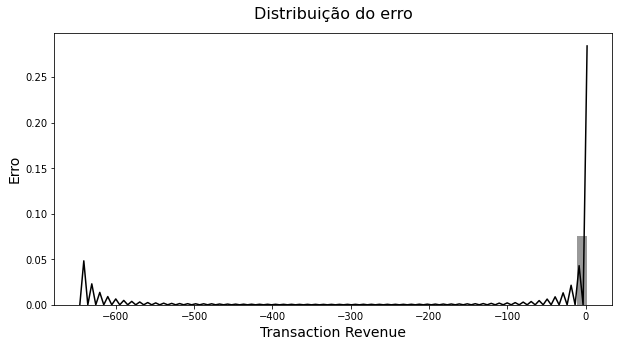

In [26]:
plt.figure(figsize=(10, 5))
sns.distplot(pred - y_test, color='k')
plt.title('Distribuição do erro', fontsize=16, y=1.03)
plt.xlabel('Transaction Revenue', fontsize=14)
plt.ylabel('Erro', fontsize=14)
plt.show()

### Melhorando a engenharia de features

#### Última visita do usuário

In [27]:
visitas_ultima =  df.groupby('fullVisitorId', as_index=False)['visitNumber'].max()
visitas_ultima.head()

,fullVisitorId,visitNumber
0,0002365800130207040,1
1,0010286039787739137,1
2,0011056874471185769,1
3,0014443856125569702,1
4,0017260116665815114,6


In [28]:
usuarios_visitas_unicos = df.drop_duplicates(subset=['fullVisitorId', 'visitNumber'])
usuarios_visitas_unicos.shape

(12270, 31)

In [29]:
visitas = pd.merge(visitas_ultima, usuarios_visitas_unicos, 
                   left_on=['fullVisitorId', 'visitNumber'], 
                   right_on=['fullVisitorId', 'visitNumber'], 
                   how='left')
print(visitas.shape)
visitas.head()

(9997, 31)


,fullVisitorId,visitNumber,channelGrouping,date,sessionId,visitId,visitStartTime,browser,operatingSystem,isMobile,...,keyword,isTrueDirect,referralPath,adContent,campaignCode,hits,pageviews,bounces,newVisits,transactionRevenue
0,0002365800130207040,1,Social,20160904,0002365800130207040_1472974804,1472974804,1472974804,Edge,Windows,False,...,NaN,NaN,/yt/about/ru/,NaN,NaN,1,1,1.0,1.0,0.0
1,0010286039787739137,1,Organic Search,20160928,0010286039787739137_1475084026,1475084026,1475084026,Chrome,Chrome OS,False,...,(not provided),NaN,NaN,NaN,NaN,4,3,NaN,1.0,0.0
2,0011056874471185769,1,Social,20161205,0011056874471185769_1480996024,1480996024,1480996024,Chrome,Windows,False,...,NaN,NaN,/yt/about/,NaN,NaN,2,2,NaN,1.0,0.0
3,0014443856125569702,1,Social,20161002,0014443856125569702_1475423502,1475423502,1475423502,Opera,Windows,False,...,NaN,NaN,/yt/about/ro/,NaN,NaN,1,1,1.0,1.0,0.0
4,0017260116665815114,6,Direct,20170420,0017260116665815114_1492707286,1492707286,1492707286,Safari,Macintosh,False,...,NaN,True,NaN,NaN,NaN,2,2,NaN,NaN,0.0


#### Primeira visita do usuário

In [30]:
visitas_primeira =  df.groupby('fullVisitorId', as_index=False)['visitNumber'].min()
visitas_primeira.set_index('fullVisitorId', inplace=True)
visitas = visitas.join(visitas_primeira, how='left', on='fullVisitorId', rsuffix='_primeira')

In [31]:
visitas = pd.merge(visitas, usuarios_visitas_unicos, 
                   left_on=['fullVisitorId', 'visitNumber_primeira'], 
                   right_on=['fullVisitorId', 'visitNumber'], 
                   how='left', suffixes=['_ultimaVisita', '_primeiraVisita'])
print(visitas.shape)
visitas.head()

(9997, 62)


,fullVisitorId,visitNumber_ultimaVisita,channelGrouping_ultimaVisita,date_ultimaVisita,sessionId_ultimaVisita,visitId_ultimaVisita,visitStartTime_ultimaVisita,browser_ultimaVisita,operatingSystem_ultimaVisita,isMobile_ultimaVisita,...,keyword_primeiraVisita,isTrueDirect_primeiraVisita,referralPath_primeiraVisita,adContent_primeiraVisita,campaignCode_primeiraVisita,hits_primeiraVisita,pageviews_primeiraVisita,bounces_primeiraVisita,newVisits_primeiraVisita,transactionRevenue_primeiraVisita
0,0002365800130207040,1,Social,20160904,0002365800130207040_1472974804,1472974804,1472974804,Edge,Windows,False,...,NaN,NaN,/yt/about/ru/,NaN,NaN,1,1,1.0,1.0,0.0
1,0010286039787739137,1,Organic Search,20160928,0010286039787739137_1475084026,1475084026,1475084026,Chrome,Chrome OS,False,...,(not provided),NaN,NaN,NaN,NaN,4,3,NaN,1.0,0.0
2,0011056874471185769,1,Social,20161205,0011056874471185769_1480996024,1480996024,1480996024,Chrome,Windows,False,...,NaN,NaN,/yt/about/,NaN,NaN,2,2,NaN,1.0,0.0
3,0014443856125569702,1,Social,20161002,0014443856125569702_1475423502,1475423502,1475423502,Opera,Windows,False,...,NaN,NaN,/yt/about/ro/,NaN,NaN,1,1,1.0,1.0,0.0
4,0017260116665815114,6,Direct,20170420,0017260116665815114_1492707286,1492707286,1492707286,Safari,Macintosh,False,...,NaN,True,NaN,NaN,NaN,2,2,NaN,NaN,0.0


#### Limpeza da base

In [32]:
for coluna in quantitativas:
    visitas.drop(coluna+'_ultimaVisita', axis=1, inplace=True)
    visitas.drop(coluna+'_primeiraVisita', axis=1, inplace=True)

In [33]:
ids = ['sessionId_ultimaVisita', 'sessionId_primeiraVisita', 'visitId_ultimaVisita', 'visitId_primeiraVisita']
visitas.drop(ids, axis=1, inplace=True)

In [34]:
geo = ['continent_primeiraVisita', 'subContinent_primeiraVisita', 'country_primeiraVisita', 'region_primeiraVisita', 
       'metro_primeiraVisita', 'city_primeiraVisita', 'networkDomain_primeiraVisita']
visitas.drop(geo, axis=1, inplace=True)

#### Criando mais algumas variáveis

In [35]:
visitas = pd.merge(visitas, df_quant, left_on=['fullVisitorId'], right_on=['fullVisitorId'], how='left')

In [36]:
visitas['tempo_dif'] = visitas['visitStartTime_ultimaVisita'] - visitas['visitStartTime_primeiraVisita']
visitas['total_visits'] = df.groupby('fullVisitorId', as_index=False).count()['visitNumber'].values

In [37]:
visitas['ano_ultima'] = pd.to_numeric([data[0:4] for data in visitas['date_ultimaVisita']])
visitas['mes_ultima'] = pd.to_numeric([data[4:6] for data in visitas['date_ultimaVisita']])
visitas['dia_ultima'] = pd.to_numeric([data[6:8] for data in visitas['date_ultimaVisita']])

visitas['ano_primeira'] = pd.to_numeric([data[0:4] for data in visitas['date_primeiraVisita']])
visitas['mes_primeira'] = pd.to_numeric([data[4:6] for data in visitas['date_primeiraVisita']])
visitas['dia_primeira'] = pd.to_numeric([data[6:8] for data in visitas['date_primeiraVisita']])

In [38]:
visitas.head()

,fullVisitorId,visitNumber_ultimaVisita,channelGrouping_ultimaVisita,date_ultimaVisita,visitStartTime_ultimaVisita,browser_ultimaVisita,operatingSystem_ultimaVisita,isMobile_ultimaVisita,deviceCategory_ultimaVisita,continent_ultimaVisita,...,pageviews,transactionRevenue,tempo_dif,total_visits,ano_ultima,mes_ultima,dia_ultima,ano_primeira,mes_primeira,dia_primeira
0,0002365800130207040,1,Social,20160904,1472974804,Edge,Windows,False,desktop,Europe,...,1,0.0,0,1,2016,9,4,2016,9,4
1,0010286039787739137,1,Organic Search,20160928,1475084026,Chrome,Chrome OS,False,desktop,Americas,...,3,0.0,0,1,2016,9,28,2016,9,28
2,0011056874471185769,1,Social,20161205,1480996024,Chrome,Windows,False,desktop,Asia,...,2,0.0,0,1,2016,12,5,2016,12,5
3,0014443856125569702,1,Social,20161002,1475423502,Opera,Windows,False,desktop,Europe,...,1,0.0,0,1,2016,10,2,2016,10,2
4,0017260116665815114,6,Direct,20170420,1492707286,Safari,Macintosh,False,desktop,Americas,...,2,0.0,0,1,2017,4,20,2017,4,20


#### Label encoder

In [39]:
visitas.drop(['fullVisitorId'], axis=1, inplace=True)

y = visitas['transactionRevenue'].copy()
X = visitas.drop(['transactionRevenue'], axis=1)

In [40]:
from sklearn.preprocessing import LabelEncoder

qualitativas = visitas.dtypes[visitas.dtypes == object].keys()
for coluna in qualitativas:
    lbl = LabelEncoder()
    strings = list(X[coluna].values.astype('str'))
    X[coluna] = lbl.fit_transform(strings)

#### Separação dos dados

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f'Treino: {X_train.shape} + {y_train.shape}')
print(f'Teste:  {X_test.shape}  + {y_test.shape}')

Treino: (6997, 52) + (6997,)
Teste:  (3000, 52)  + (3000,)


#### Regressão Linear

In [42]:
reg = LinearRegression()
_ = reg.fit(X_train, y_train)

pred = reg.predict(X_test)
pred[pred < 0] = 0

#### Avaliando o resultado

In [43]:
resultados = pd.DataFrame({'revenue': y_test, 'predict': pred, 'erro': pred - y_test})
resultados.head()

,revenue,predict,erro
4122,0.0,0.059646,0.059646
4065,0.0,0.000000,0.000000
1731,0.0,0.000000,0.000000
4740,0.0,0.437595,0.437595
6391,0.0,0.000000,0.000000


In [45]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, pred))}')
print('Media de gasto: ', np.mean(df_quant['transactionRevenue']))
print('Desvio padrão: ', np.std(df_quant['transactionRevenue']))

RMSE: 25.032867765858477
Media de gasto:  1.778953686105831
Desvio padrão:  25.129905708017944


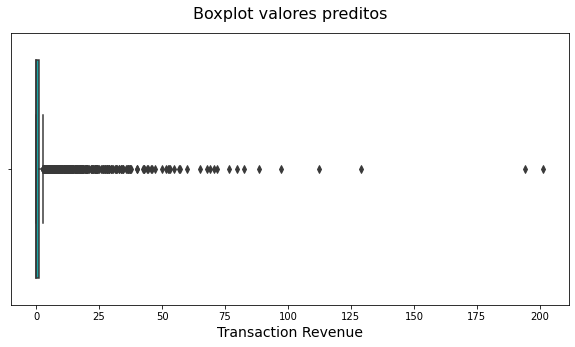

In [46]:
plt.figure(figsize=(10, 5))
sns.boxplot(pred, color='c')
plt.title('Boxplot valores preditos', fontsize=16, y=1.03)
plt.xlabel('Transaction Revenue', fontsize=14)
plt.show()

#### Gradient boosting

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
_ = gbr.fit(X_train, y_train)
pred = gbr.predict(X_test)
pred[pred < 0] = 0

In [49]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, pred))}')
print('Media de gasto: ', np.mean(df_quant['transactionRevenue']))
print('Desvio padrão: ', np.std(df_quant['transactionRevenue']))

RMSE: 23.09413632899293
Media de gasto:  1.778953686105831
Desvio padrão:  25.129905708017944


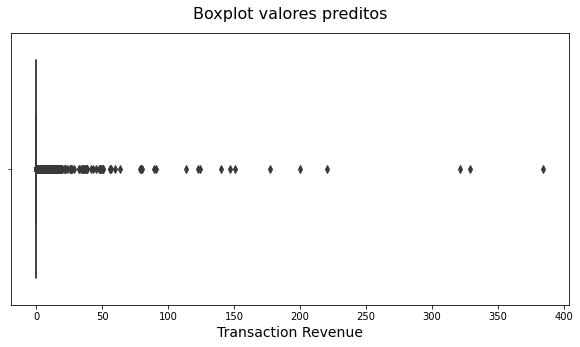

In [50]:
plt.figure(figsize=(10, 5))
sns.boxplot(pred, color='c')
plt.title('Boxplot valores preditos', fontsize=16, y=1.03)
plt.xlabel('Transaction Revenue', fontsize=14)
plt.show()